## Adjusted furniture prices from 1992 to 2019

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')  # Fondo oscuro

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2

# Arima Modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# ML Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Functions
def evaluation_metrics_ts(y_real, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score

    metrics= {}
    metrics['MSE']= mean_squared_error(y_real, y_pred)
    metrics['MAE']= mean_absolute_error(y_real, y_pred)
    metrics['RMSE']= root_mean_squared_error(y_real, y_pred)
    metrics['MAPE']= mean_absolute_percentage_error(y_real,y_pred)
    metrics['R2']= r2_score(y_real,y_pred)
    return metrics

def Dickey_Fuller_test(series): # La prueba de dickey_fuller pero muy intuitiva
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No. lags Used','No. observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print('------------')
    if dftest[1] <= 0.05:
        print("The data are stationary")
    else:
        print("The data is not stationary")

In [3]:
df = pd.read_csv("df_furniture.csv")
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     331 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [5]:
df= df.rename({'Month': 'date', 'furniture_price_adjusted': 'price'}, axis=1 )
df['date'] = pd.to_datetime(df['date'])

### Clasical model: SARIMA

In [6]:
df1= df.copy()
df1 = df1.set_index('date')
df1.index.freq = 'MS' # month start frequency
df1.head()

,price
date,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [7]:
df1.index.duplicated().sum()

0

In [8]:
df1.isnull().sum()

price    0
dtype: int64

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1992-01-01 to 2019-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   331 non-null    float64
dtypes: float64(1)
memory usage: 13.3 KB


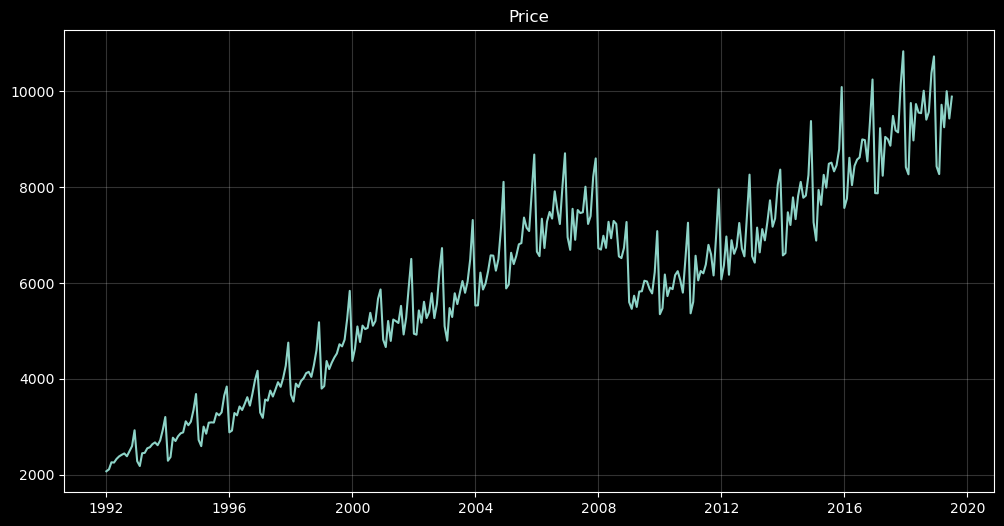

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df1.index, df1['price'])
plt.title('Price')
plt.show()

When we look at the graph, we can see that there is seasonality in the data. That is why we will use SARIMA, instead of ARIMA.

It seems that the series is not stationary due to its increasing trend.

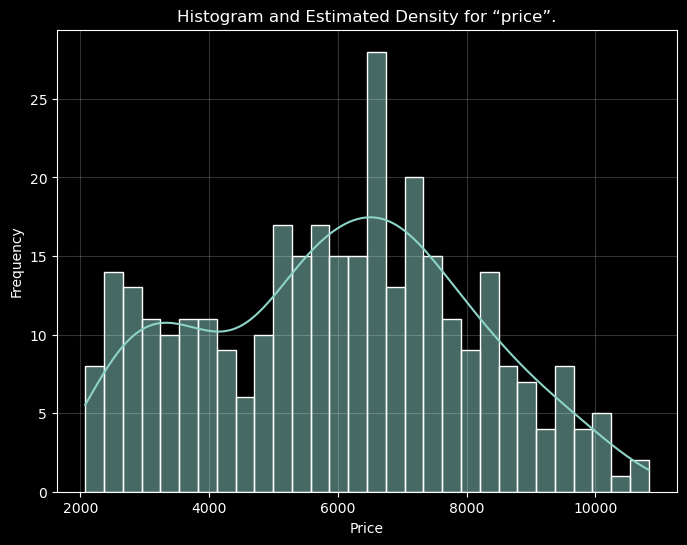

In [11]:
plt.figure(figsize=(8,6))
sns.histplot(df1['price'], kde=True, bins=30)
plt.title('Histogram and Estimated Density for “price”.')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [12]:
Dickey_Fuller_test(df1)

Test Statistic            -1.128551
p-value                    0.703553
No. lags Used             14.000000
No. observations used    316.000000
Critical Value (1%)       -3.451215
Critical Value (5%)       -2.870730
Critical Value (10%)      -2.571666
dtype: float64
------------
The data is not stationary


In [13]:
df1_diff= df1.diff().dropna()

In [14]:
Dickey_Fuller_test(df1_diff)

Test Statistic            -3.117451
p-value                    0.025288
No. lags Used             17.000000
No. observations used    312.000000
Critical Value (1%)       -3.451484
Critical Value (5%)       -2.870849
Critical Value (10%)      -2.571730
dtype: float64
------------
The data are stationary


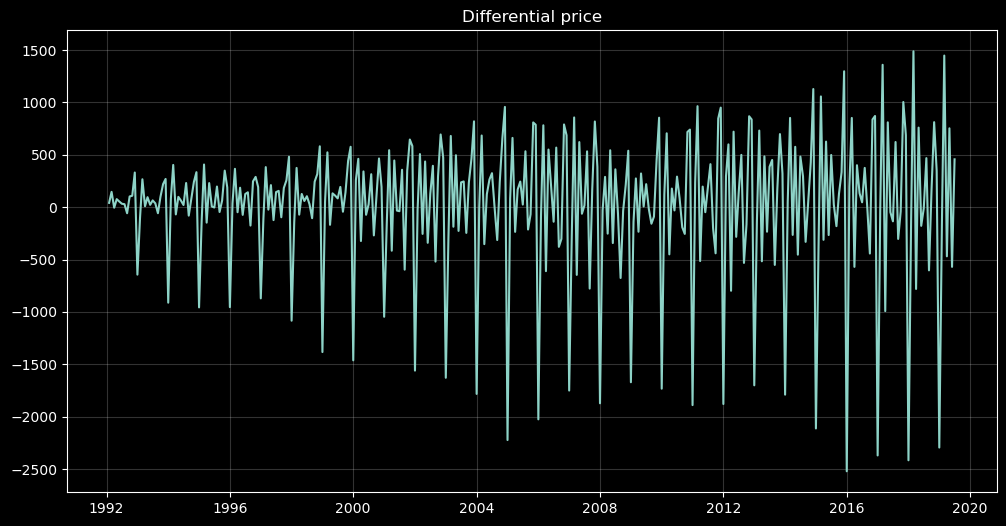

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df1_diff.index, df1_diff)
plt.title('Differential price')
plt.show()

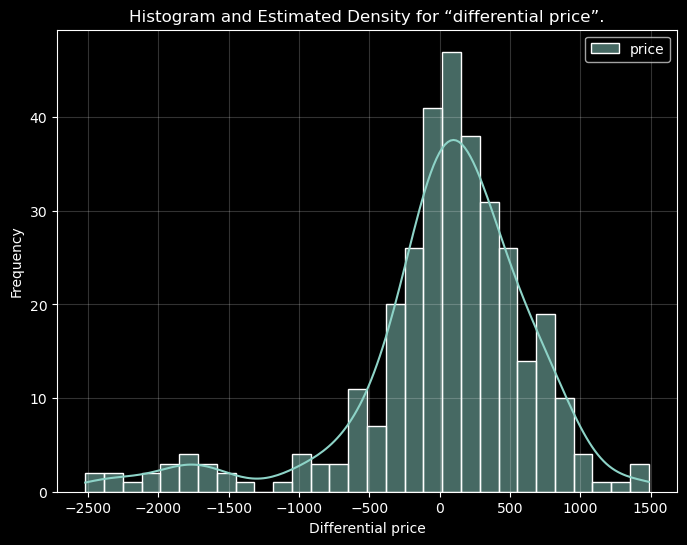

In [16]:
plt.figure(figsize=(8,6))
sns.histplot(df1_diff, kde=True, bins=30)
plt.title('Histogram and Estimated Density for “differential price”.')
plt.xlabel('Differential price')
plt.ylabel('Frequency')
plt.show()

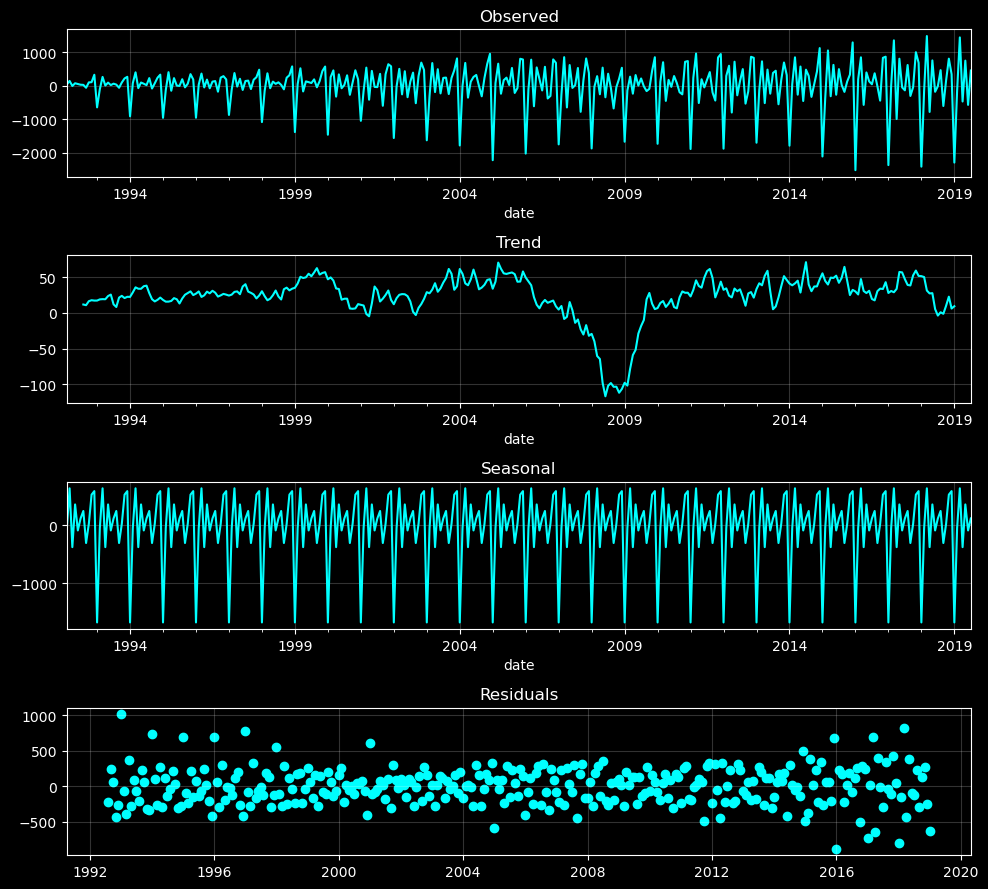

In [17]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the series
result = seasonal_decompose(df1_diff, model='add')

# Create a figure
fig, axes = plt.subplots(4, 1, figsize=(10, 9))

# Plot sub-series
result.observed.plot(ax=axes[0], color='cyan')
axes[0].set_title('Observed')

result.trend.plot(ax=axes[1], color='cyan')
axes[1].set_title('Trend')

result.seasonal.plot(ax=axes[2], color='cyan')
axes[2].set_title('Seasonal')

# Change the residuals to a scatter plot
axes[3].scatter(df1_diff.index, result.resid, color='cyan')
axes[3].set_title('Residuals')

plt.tight_layout()
plt.show()

The seasonal plot shows that there is seasonality, so we will use a SARIMA model.

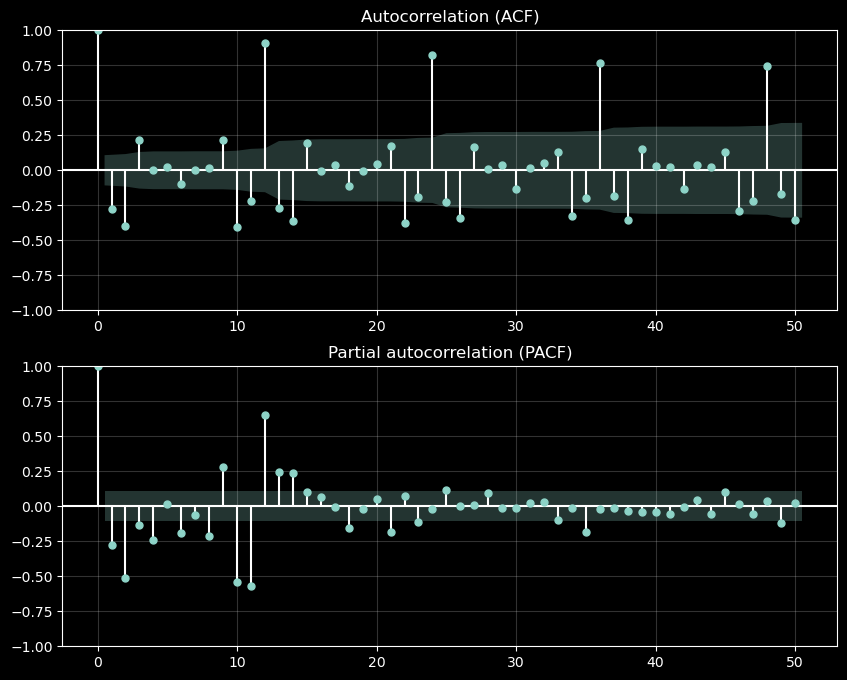

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Autocorrelation plot (ACF)
plot_acf(df1_diff, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation (ACF)')

# Partial autocorrelation plot (PACF)
plot_pacf(df1_diff, lags=50, ax=ax[1])
ax[1].set_title('Partial autocorrelation (PACF)')

plt.show()

In [19]:
train_data = df1[:len(df1)-24].copy()
test_data = df1[len(df1)-24:].copy()

train_data.shape, test_data.shape

((307, 1), (24, 1))

In [18]:
modelo_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4008.395, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3946.781, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3918.134, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3937.512, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3903.385, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3928.870, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3900.423, Time=0.85 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3919.367, Time=0.32 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3892.652, Time=1.99 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3902.552, Time=1.05 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=3894.650, Time=2.32 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=3894.649, Time=2.56 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(1,1,2)(2,1,2)[12]     

In [19]:
print(modelo_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  307
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1940.326
Date:                                 Thu, 26 Sep 2024   AIC                           3892.652
Time:                                         23:30:56   BIC                           3914.753
Sample:                                     01-01-1992   HQIC                          3901.503
                                          - 07-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4039      0.044     -9.221      0.000      -0.490      -0

### Model Implementation

In [20]:
arima_model = SARIMAX(train_data, order = (0,1,1), seasonal_order = (2,1,2,12)) 
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   price   No. Observations:                  307
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1940.326
Date:                                 Fri, 27 Sep 2024   AIC                           3892.652
Time:                                         00:51:39   BIC                           3914.753
Sample:                                     01-01-1992   HQIC                          3901.503
                                          - 07-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4039      0.044     -9.221      0.000      -0.490      -0.318
ar.S.L12       0.8836      0.099      8.907      0.000       0.689       1.078
ar.S.L24      -0.7583      0.088     -8.622      0.000      -0.931      -0.586
ma.S.L12      -1.1372      0.117     -9.726      0.000      -1.366      -0.908
ma.S.L24       0.7168      0.109      6.603      0.000       0.504       0.930
sigma2      3.055e+04   2174.638     14.051      0.000    2.63e+04    3.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.11   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

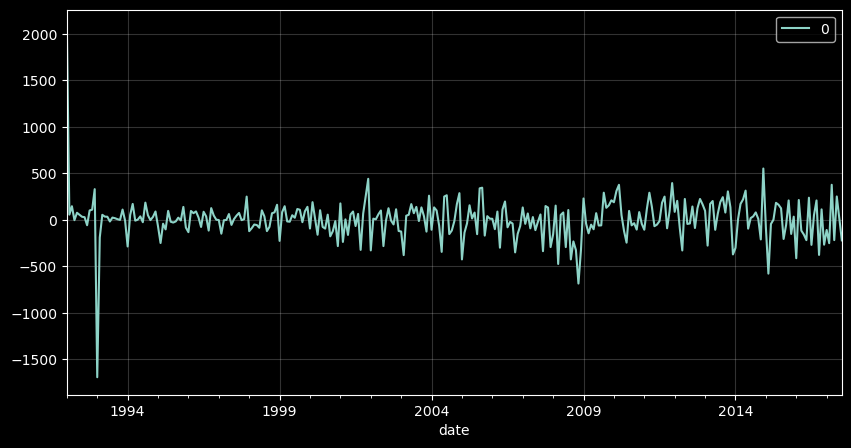

In [21]:
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (10,5));
plt.show();

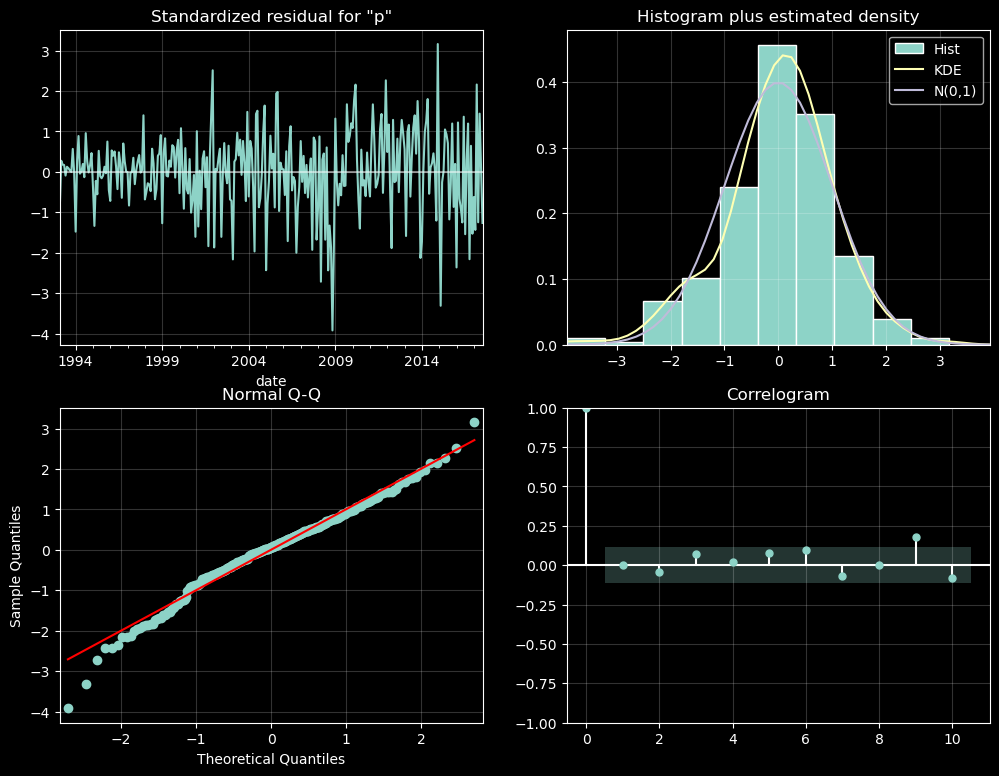

In [22]:
# Diagnostic Plots

arima_result.plot_diagnostics(figsize=(12,9)) # Aplicar grid a todas las graficas
plt.show()

Residuals oscillate around zero, with no visible patterns or systematic trends.

The residuals are well distributed and fit a normal distribution, so the model is adequate.

The points follow the line fairly well, suggesting that the residuals are reasonably normalized.

There are no bars protruding from the confidence intervals, suggesting that the residuals are not autocorrelated.

In [23]:
arima_pred= arima_result.predict(start= test_data.index[0],end= test_data.index[-1])

In [24]:
test_data.loc[test_data.index, 'ARIMA_predictions'] = arima_pred[test_data.index]
test_data.head()

,price,ARIMA_predictions
date,,
2017-08-01,9485.837200,9478.323811
2017-09-01,9182.448031,9305.115706
2017-10-01,9141.979154,8987.410083
2017-11-01,10145.590406,9867.659215
2017-12-01,10833.501852,10656.447038


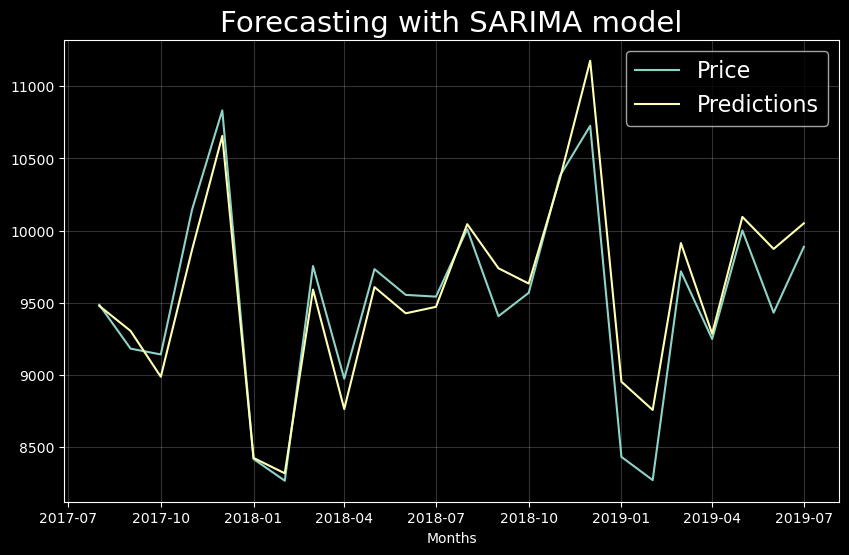

In [25]:
plt.figure(figsize=(10,6))
plt.plot(test_data['price'], label='Price')
plt.plot(test_data['ARIMA_predictions'], label='Predictions')
plt.title('Forecasting with SARIMA model', fontsize=21);
plt.xlabel('Months')
plt.legend( fontsize=16);
plt.show();

In [26]:
evaluation_metrics_ts(test_data['price'], test_data['ARIMA_predictions'])

{'MSE': 56489.72699051525,
 'MAE': 180.6020765913846,
 'RMSE': 237.67567605986787,
 'MAPE': 0.019266733578785993,
 'R2': 0.8793605226532115}

### ML
#### Feature engenering

In [27]:
df2= df.copy()

In [28]:
df2['year'] = df2['date'].apply(lambda x: x.year)
df2['month'] = df2['date'].apply(lambda x: x.month)
df2['quarter'] = df2['date'].apply(lambda x: x.quarter)
df2= df2.set_index('date')

df2['L1'] = df2['price'].shift(1)
df2['L2'] = df2['price'].shift(2)
df2['L3'] = df2['price'].shift(3)
df2['L4'] = df2['price'].shift(4)
df2['L5'] = df2['price'].shift(5)
df2['L6'] = df2['price'].shift(6)
df2['L7'] = df2['price'].shift(7)
df2['L8'] = df2['price'].shift(8)
df2['L9'] = df2['price'].shift(9)
df2['L10'] = df2['price'].shift(10)
df2['L11'] = df2['price'].shift(11)
df2['L12'] = df2['price'].shift(12)

df2['MA_3'] = df2['price'].rolling(window=3).mean()

df2['MA_6'] = df2['price'].rolling(window=6).mean()

df2['MA_12'] = df2['price'].rolling(window=12).mean()

df2.dropna(inplace=True)
df2.head()

,price,year,month,quarter,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,MA_3,MA_6,MA_12
date,,,,,,,,,,,,,,,,,,,
1993-01-01,2284.619439,1993,1,1,2928.725684,2598.186297,2489.350838,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618,2255.103236,2260.570891,2114.485812,2073.432724,2603.843807,2522.288782,2408.092599
1993-02-01,2183.137948,1993,2,1,2284.619439,2928.725684,2598.186297,2489.350838,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618,2255.103236,2260.570891,2114.485812,2465.494357,2478.561985,2413.813611
1993-03-01,2449.195623,1993,3,1,2183.137948,2284.619439,2928.725684,2598.186297,2489.350838,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618,2255.103236,2260.570891,2305.651003,2488.869305,2429.532338
1993-04-01,2457.704334,1993,4,2,2449.195623,2183.137948,2284.619439,2928.725684,2598.186297,2489.350838,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618,2255.103236,2363.345969,2483.594888,2446.415763
1993-05-01,2552.874950,1993,5,2,2457.704334,2449.195623,2183.137948,2284.619439,2928.725684,2598.186297,2489.350838,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618,2486.591636,2476.042996,2464.870791


### Decisión Tree Modeling
### Training, validation and evaluation

In [29]:
x, y= df2.drop(['price'], axis= 1), df2['price']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.075, random_state=123, shuffle=False)
len(x_train), len(x_test)

(295, 24)

In [31]:
dt = DecisionTreeRegressor(random_state=123)
# Model training
dt.fit(x_train, y_train)
# Predictions
y_pred_dt=dt.predict(x_test)

# Training and validation scores
print('training_score:', dt.score(x_train, y_train))
print('test_score:', dt.score(x_test, y_test))

training_score: 1.0
test_score: 0.41175281801812635


In [32]:
test_data['Decision_tree_pred']= y_pred_dt

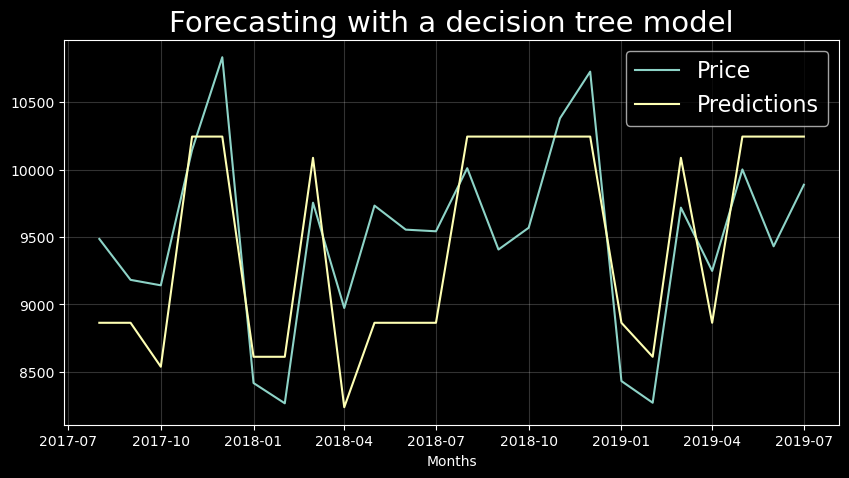

In [33]:
plt.figure(figsize=(10,5))
plt.plot(test_data['price'], label='Price')
plt.plot(test_data['Decision_tree_pred'], label='Predictions')
plt.title('Forecasting with a decision tree model', fontsize=21);
plt.xlabel('Months')
plt.legend( fontsize=16);
plt.show();

In [34]:
evaluation_metrics_ts(test_data['price'], test_data['Decision_tree_pred'])

{'MSE': 275448.16542576463,
 'MAE': 474.368405351843,
 'RMSE': 524.8315590985022,
 'MAPE': 0.05016186828811366,
 'R2': 0.41175281801812635}

### Random Forest Modeling
### Training, validation and evaluation

In [35]:
# Creating the model with 1,000 trees
rfr = RandomForestRegressor(n_estimators=1000, random_state=123)

# Model training
rfr.fit(x_train, y_train)

# Predictions
y_pred_rfr= rfr.predict(x_test)

# Training and validation scores
print('training_score:', rfr.score(x_train, y_train))
print('test_score:', rfr.score(x_test, y_test))

training_score: 0.9970056792330392
test_score: 0.6206789706461917


In [36]:
test_data['Random_forest_pred']= y_pred_rfr

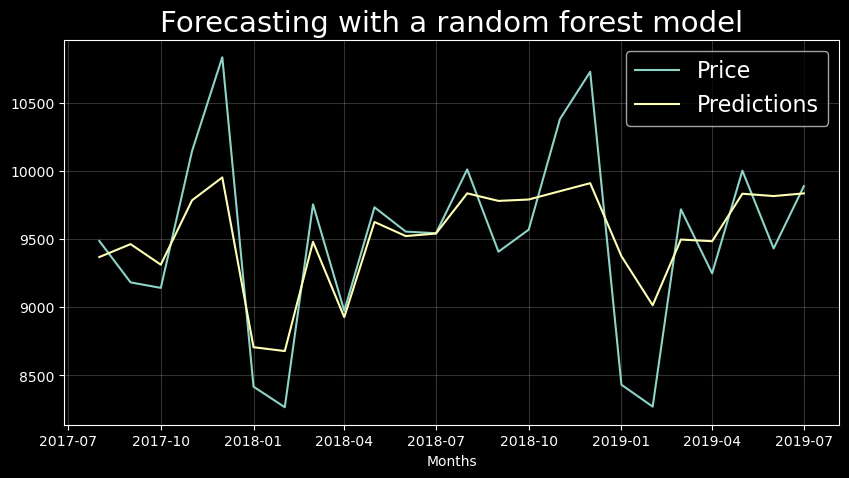

In [37]:
plt.figure(figsize=(10,5))
plt.plot(test_data['price'], label='Price')
plt.plot(test_data['Random_forest_pred'], label='Predictions')
plt.title('Forecasting with a random forest model', fontsize=21);
plt.xlabel('Months')
plt.legend( fontsize=16);
plt.show();

In [38]:
evaluation_metrics_ts(test_data['price'], test_data['Random_forest_pred'])

{'MSE': 177617.98924544393,
 'MAE': 326.6786320294387,
 'RMSE': 421.4474928688554,
 'MAPE': 0.03462809966384747,
 'R2': 0.6206789706461917}

### Summary

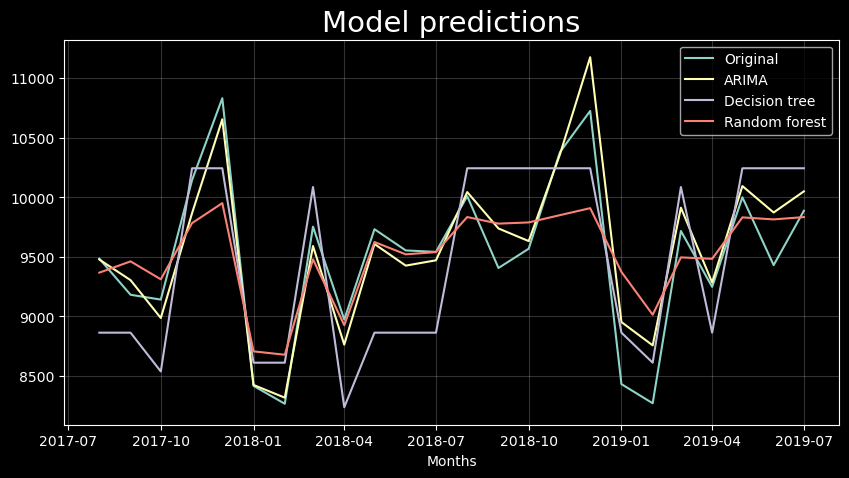

In [39]:
plt.figure(figsize=(10,5))
plt.plot(test_data['price'], label='Original')
plt.plot(test_data['ARIMA_predictions'], label='ARIMA')
plt.plot(test_data['Decision_tree_pred'], label='Decision tree')
plt.plot(test_data['Random_forest_pred'], label='Random forest')
plt.title('Model predictions', fontsize=21);
plt.xlabel('Months')
plt.legend()
plt.show();

In [40]:
evaluation_metrics_ts(test_data['price'], test_data['ARIMA_predictions'])

{'MSE': 56489.72699051525,
 'MAE': 180.6020765913846,
 'RMSE': 237.67567605986787,
 'MAPE': 0.019266733578785993,
 'R2': 0.8793605226532115}

In [41]:
evaluation_metrics_ts(test_data['price'], test_data['Decision_tree_pred'])

{'MSE': 275448.16542576463,
 'MAE': 474.368405351843,
 'RMSE': 524.8315590985022,
 'MAPE': 0.05016186828811366,
 'R2': 0.41175281801812635}

In [42]:
evaluation_metrics_ts(test_data['price'], test_data['Random_forest_pred'])

{'MSE': 177617.98924544393,
 'MAE': 326.6786320294387,
 'RMSE': 421.4474928688554,
 'MAPE': 0.03462809966384747,
 'R2': 0.6206789706461917}